In [1]:
# 主文件，包含了整个论文的行文结构

In [2]:

%reload_ext autoreload
%autoreload 2

# %% 0. 导入必要的库
import sys
import uuid
import numpy as np
import arrow

sys.path.append('B://workspace/tensorflow')

from src.analysis.season import SeasonalityAnalysis
from src.analysis.rmse import plot_metrics

from src.trainer.base import BaseTrainer

from src.models.LSTM import LSTM
from src.models.ConvLSTM import ConvLSTM
from src.models.UNetLSTM import UNetLSTM
from src.models.Transformer import SSTTransformer
from src.models.RATransformer import RecursiveAttentionTransformer

from src.config.area import Area
from src.config.params import MODEL_SAVE_PATH
from src.dataset.ERA5 import ERA5SSTMonthlyDataset

from src.analysis.prediction import analyze_model_performance

In [ ]:
# %% 1. 数据集分析

## 1.1 ERA5 月平均数据

### 1.1.1 时间序列的周期性分析

dataset = ERA5SSTMonthlyDataset(
    seq_len=1,
    offset=0,
    lon=np.array([-180, 180]),  # 全球区域
    lat=np.array([-80, 80])    # 全球区域
)

analyzer = SeasonalityAnalysis(dataset)

# 绘制季节性图表
fig = analyzer.plot_seasonal_patterns()

In [4]:
# %% 2. 模型构建

## 2.1 不同的训练器

area = Area('Global', lon=[-180, 180], lat=[-80, 80], description='全球区域')

trainer_uid = str(uuid.uuid4())
resolution = 2
seq_len = 6
offset = 0

pre_model = False

width = int(area.width / resolution)
height = int(area.height / resolution)

model_path = f"{MODEL_SAVE_PATH}/seq_len-{seq_len}"

dataset_params = {
    "seq_len": seq_len,
    "offset": offset,
    "resolution": resolution,
}

lstm_m_params = {
    "width": width,
    "height": height,
    "seq_len": seq_len,
    "hidden_dim": 512,
    "num_layers": 6,
    "dropout": 0.1,
}

conv_m_params = {
    'input_dim': 1,  # 输入通道数
    'hidden_dim': 1,  # 隐藏层通道数
    'kernel_size': (5, 5),  # 卷积核大小
    'num_layers': 1,  # LSTM层数
    'bias': False  # 是否使用偏置
}

unet_lstm_m_params = {
    "input_channels": 1,
    "output_channels": 1,
    "features": [32, 64, 128, 256],
    "lstm_hidden_channels": 1024,
    "learning_rate": 1e-3
}

transformer_m_params = {
    "width": width,
    "height": height,
    "seq_len": seq_len,
    "d_model": 1024,
    "nhead": 8,
    "num_encoder_layers": 2,
    "num_decoder_layers": 2,
    "dim_feedforward": 512,
    "dropout": 0.1,
    "learning_rate": 1e-3
}

ra_transformer_m_params = {
    "width": width,
    "height": height,
    "seq_len": seq_len,
    "d_model": 1024, 
    "num_heads": 8, 
    "num_layers": 3,
    "dim_feedforward": 1024,
    "dropout": 0.1,
    "recursion_depth": 2,
    "learning_rate": 1e-3,
}

trainer_params = {
    "epochs": 500,
    "batch_size": 20,
}

lstm_trainer = BaseTrainer(
    title='LSTM',
    area=area,
    uid=trainer_uid,
    model_class=LSTM,
    dataset_class=ERA5SSTMonthlyDataset,
    save_path=f'{model_path}/lstm.pkl',
    pre_model=pre_model,
    dataset_params=dataset_params,
    trainer_params=trainer_params,
    model_params=lstm_m_params,
)

conv_trainer = BaseTrainer(
    title='ConvLSTM',
    area=area,
    uid=trainer_uid,
    model_class=ConvLSTM,
    dataset_class=ERA5SSTMonthlyDataset,
    save_path=f'{model_path}/conv.pkl',
    pre_model=pre_model,
    dataset_params=dataset_params,
    trainer_params=trainer_params,
    model_params=conv_m_params,
)

unet_lstm_trainer = BaseTrainer(
    title='UNetLSTM',
    area=area,
    uid=trainer_uid,
    model_class=UNetLSTM,
    dataset_class=ERA5SSTMonthlyDataset,
    save_path=f'{model_path}/unet.pkl',
    pre_model=pre_model,
    dataset_params=dataset_params,
    trainer_params=trainer_params,
    model_params=unet_lstm_m_params,
)

transformer_trainer = BaseTrainer(
    title='Transformer',
    area=area,
    uid=trainer_uid,
    model_class=SSTTransformer,
    dataset_class=ERA5SSTMonthlyDataset,
    save_path=f'{model_path}/transformer.pkl',
    pre_model=pre_model,
    dataset_params=dataset_params,
    trainer_params=trainer_params,
    model_params=transformer_m_params,
)


ra_transformer_trainer = BaseTrainer(
    title='RATransformer',
    area=area,
    uid=trainer_uid,
    model_class=RecursiveAttentionTransformer,
    dataset_class=ERA5SSTMonthlyDataset,
    save_path=f'{model_path}/ra_transformer.pkl',
    pre_model=pre_model,
    dataset_params=dataset_params,
    trainer_params=trainer_params,
    model_params=ra_transformer_m_params,
)

In [5]:
trainers = [
    # lstm_trainer,
    # conv_trainer,
    # unet_lstm_trainer,
    # transformer_trainer,
    # ra_transformer_trainer
]

for trainer in trainers: 
    trainer.train()

In [ ]:
# %% 4. 模型评估

## 4.1 预测

months = [ i for i in range(248, 256) ]

RMSE = {
    'LSTM': [], 
    'ConvLSTM': [],
    'UNetLSTM': [],
    'Transformer': [],
    'RATransformer': []
}
R2 = {
    'LSTM': [],
    'ConvLSTM': [],
    'UNetLSTM': [],
    'Transformer': [],
    'RATransformer': []
}

p_trainers = [
    lstm_trainer,
    conv_trainer,
    unet_lstm_trainer,
    transformer_trainer,
    ra_transformer_trainer
]

for trainer in p_trainers:
    title = trainer.title
    
    for month in months:
        offset = month
        input, output, pred_output, rmse, r2 = trainer.predict(offset, plot=True)
        RMSE[title].append(rmse)
        R2[title].append(r2)

print(RMSE)
print(R2)   


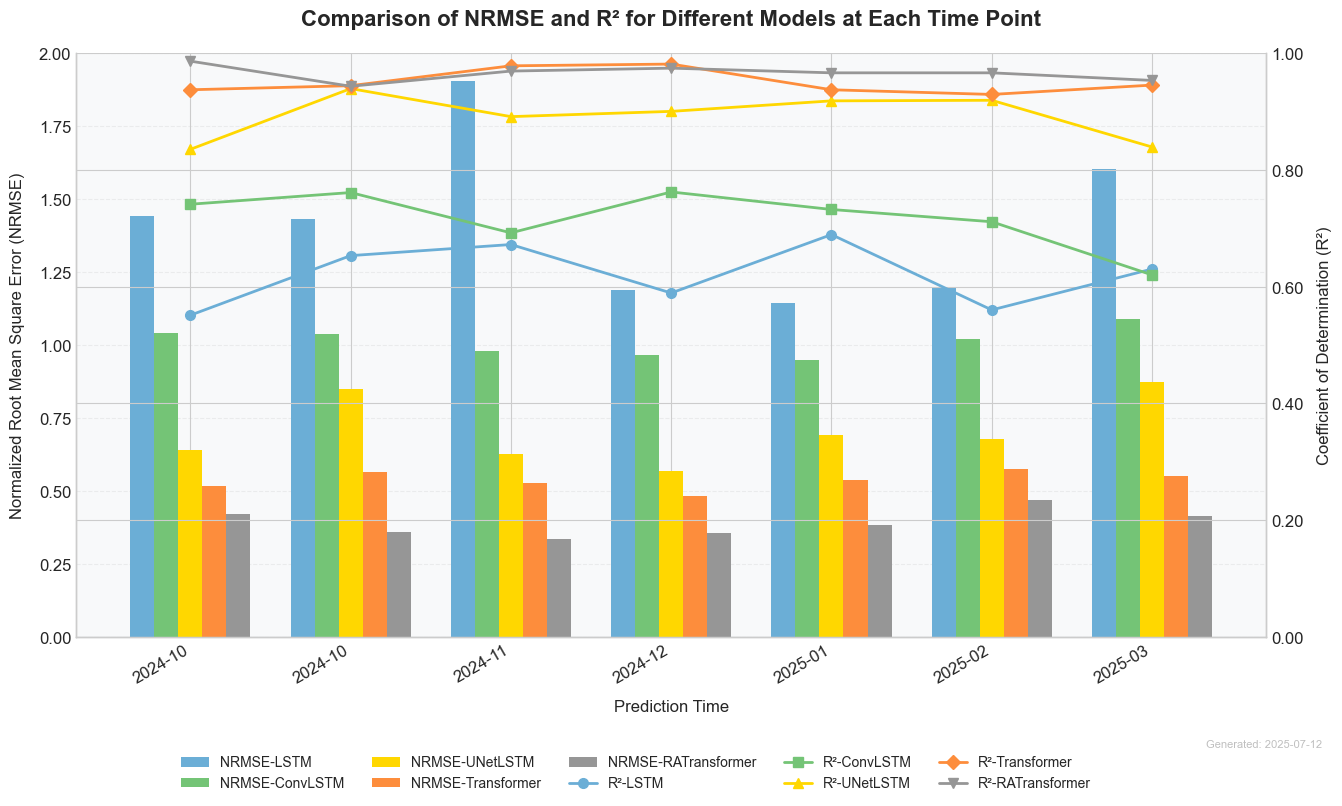

In [4]:
# %% 5. 结果分析
# analyze_model_performance()

plot_metrics()




In [8]:
# %% 6. 消融实验

# %% 6.1 消融实验是 RA-Transformer 和 Transformer 的对比



# %%